In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from dice_rl_TU_Vienna.value import get_success_rate_dataset, get_get_policy_value_dataset
from dice_rl_TU_Vienna.environment import test_env
from dice_rl_TU_Vienna.estimators.tabular.test import test_estimator, test_aux_estimates

from dice_rl_TU_Vienna.plot.tabular import plot_observations, plot_success_rate_pv_error, plot_pvs
from dice_rl_TU_Vienna.estimators.get import (
    get_gammas_1, get_gammas_2,
    get_pv_s_OnPE, get_pv_s_OffPE, )

from dice_rl_TU_Vienna.estimators.tabular.aux_estimates.io import load_or_create_aux_estimates
from dice_rl_TU_Vienna.estimators.tabular.bellman_equations import solve_backwards_bellman_equations_approximate
from dice_rl_TU_Vienna.estimators.tabular.tabular_vafe          import TabularVafe
from dice_rl_TU_Vienna.estimators.tabular.tabular_dice          import TabularDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_dual_dice     import TabularDualDice
from dice_rl_TU_Vienna.estimators.tabular.tabular_gradient_dice import TabularGradientDice

from plugins.medical_rl.sepsis_amsterdam.tabular.config import *
from plugins.medical_rl.sepsis_amsterdam.tabular.test.dataset import display_episodes_dataframe_dataset

from utils.bedtime import computer_sleep

In [5]:
pd.set_option("display.max_rows", 256)
pd.set_option("display.max_column", 100)

# Values

In [66]:
get_policy_value = {}
rewards = {}

for k in K:
    x, y = get_get_policy_value_dataset(dataset=dataset[k])

    get_policy_value[k] = x
    rewards[k] = y

100%|██████████| 10000/10000 [00:10<00:00, 934.73it/s]


In [67]:
for k in K:
    get_policy_value[k].__name__ = f"OnPE {names[k]}"

In [12]:
success_rates = {}

for k in K:
    success_rates[k] = get_success_rate_dataset(
        dataset[k], by="steps")

100%|██████████| 10000/10000 [00:06<00:00, 1603.96it/s]


In [17]:
success_rate = { k: success_rates[k][-1] for k in K }

# `aux_estimates`

In [22]:
aux_estimates = {
    k: load_or_create_aux_estimates(
        aux_estimates_dir=save_dir[k],
        dataset=dataset[k],
        target_policy=evaluation_policy,
        by="steps",
    )
        for k in K
}

loaded data/medical_rl/outputs/split=(0.4, 0.1, 0.5)_seed=42_column_labels_id=2_n_clusters=256_n_init=10/total_timesteps=100000/n_pads=1/by=steps_obs_act=True/d0_bar.npy
loaded data/medical_rl/outputs/split=(0.4, 0.1, 0.5)_seed=42_column_labels_id=2_n_clusters=256_n_init=10/total_timesteps=100000/n_pads=1/by=steps_obs_act=True/dD_bar.npy
loaded data/medical_rl/outputs/split=(0.4, 0.1, 0.5)_seed=42_column_labels_id=2_n_clusters=256_n_init=10/total_timesteps=100000/n_pads=1/by=steps_obs_act=True/P_bar.npy
loaded data/medical_rl/outputs/split=(0.4, 0.1, 0.5)_seed=42_column_labels_id=2_n_clusters=256_n_init=10/total_timesteps=100000/n_pads=1/by=steps_obs_act=True/r_bar.npy
loaded data/medical_rl/outputs/split=(0.4, 0.1, 0.5)_seed=42_column_labels_id=2_n_clusters=256_n_init=10/total_timesteps=100000/n_pads=1/by=steps_obs_act=True/n.npy
loaded data/medical_rl/outputs/split=(0.4, 0.1, 0.5)_seed=42_column_labels_id=2_n_clusters=256_n_init=10/total_timesteps=100000/total_timesteps=10000_num_tra

# Estimators

In [68]:
estimators_OnPE = get_policy_value

estimators_VAFE = {
    k: [ TabularVafe(aux_estimates=aux_estimates[k], num_obs=n_clusters+2, n_act=5), ]
        for k in K
}

estimators_DICE = {}

for k in K:
    args = [ dataset[k], evaluation_policy, aux_estimates[k],    ]
    estimators_DICE[k] = [ TabularDice(*args), TabularDualDice(*args), TabularGradientDice(*args), ]

estimators_OffPE = {
    k: estimators_VAFE[k] + estimators_DICE[k]
        for k in K
}

# `get_pvs`

In [24]:
gammas_1 = get_gammas_1()
gammas_2 = get_gammas_2()

projected = True
modified = True
lam = 1e-6

In [76]:
# pvs_OnPE

pvs_OnPE_1 = {
    k: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[k],
        gamma_s=gammas_1,
    )
        for k in K
}

pvs_OnPE_2 = {
    k: get_pv_s_OnPE(
        estimator_s=estimators_OnPE[k],
        gamma_s=gammas_2,
    )
        for k in K
}

OnPE original


100%|██████████| 9/9 [00:00<00:00, 293.63it/s]


OnPE exploratory


100%|██████████| 9/9 [00:00<00:00, 558.03it/s]


OnPE evaluation


100%|██████████| 9/9 [00:00<00:00, 61.68it/s]


OnPE original


100%|██████████| 17/17 [00:00<00:00, 336.03it/s]


OnPE exploratory


100%|██████████| 17/17 [00:00<00:00, 429.96it/s]


OnPE evaluation


100%|██████████| 17/17 [00:00<00:00, 256.40it/s]


In [79]:
# pvs_OffPE

pvs_VAFE_1 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_VAFE[k],
        gamma_s=gammas_1,
        projected=projected, weighted=None,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_VAFE_2 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_VAFE[k],
        gamma_s=gammas_2,
        projected=projected, weighted=None,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_s_1 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_1,
        projected=projected, weighted=False,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_DICE_s_2 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_2,
        projected=projected, weighted=False,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_w_1 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_1,
        projected=projected, weighted=True,
        modified=modified, lam=lam,
    )
        for k in K
}

pvs_DICE_w_2 = {
    k: get_pv_s_OffPE(
        estimator_s=estimators_DICE[k],
        gamma_s=gammas_2,
        projected=projected, weighted=True,
        modified=modified, lam=lam,
    )
        for k in K
}

print("\n", "#", "-"*64, "#", "\n")

pvs_DICE_1 = { False: pvs_DICE_s_1, True: pvs_DICE_w_1, }
pvs_DICE_2 = { False: pvs_DICE_s_2, True: pvs_DICE_w_2, }

TabularVafe


100%|██████████| 9/9 [00:01<00:00,  7.89it/s]


TabularVafe


100%|██████████| 9/9 [00:01<00:00,  6.71it/s]


TabularVafe


100%|██████████| 9/9 [00:00<00:00, 11.64it/s]


TabularVafe


100%|██████████| 17/17 [00:01<00:00, 12.34it/s]


TabularVafe


100%|██████████| 17/17 [00:01<00:00, 14.76it/s]


TabularVafe


100%|██████████| 17/17 [00:00<00:00, 20.65it/s]



 # ---------------------------------------------------------------- # 

TabularDice


100%|██████████| 9/9 [00:00<00:00, 30.18it/s]


TabularDualDice


100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


TabularGradientDice


 11%|█         | 1/9 [00:00<00:03,  2.57it/s]/Users/richardweiss/Library/CloudStorage/OneDrive-Persönlich/Masterarbeit/dice_rl_TU_Vienna/dice_rl_plugins/estimators/tabular/tabular_dice.py:38: UserWarning: negative sdc value encountered
  warnings.warn("negative sdc value encountered", UserWarning)
100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


TabularDice


100%|██████████| 9/9 [00:00<00:00, 25.76it/s]


TabularDualDice


100%|██████████| 9/9 [00:03<00:00,  2.87it/s]


TabularGradientDice


100%|██████████| 9/9 [00:03<00:00,  2.96it/s]


TabularDice


100%|██████████| 9/9 [00:00<00:00, 32.40it/s]


TabularDualDice


100%|██████████| 9/9 [00:02<00:00,  3.36it/s]


TabularGradientDice


100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


TabularDice


100%|██████████| 17/17 [00:00<00:00, 73.41it/s]


TabularDualDice


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


TabularGradientDice


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


TabularDice


100%|██████████| 17/17 [00:00<00:00, 30.63it/s]


TabularDualDice


100%|██████████| 17/17 [00:06<00:00,  2.69it/s]


TabularGradientDice


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


TabularDice


100%|██████████| 17/17 [00:00<00:00, 30.38it/s]


TabularDualDice


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


TabularGradientDice


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]



 # ---------------------------------------------------------------- # 

TabularDice


100%|██████████| 9/9 [00:00<00:00, 51.43it/s]


TabularDualDice


100%|██████████| 9/9 [00:03<00:00,  2.37it/s]


TabularGradientDice


100%|██████████| 9/9 [00:04<00:00,  2.17it/s]


TabularDice


100%|██████████| 9/9 [00:00<00:00,  9.59it/s]


TabularDualDice


100%|██████████| 9/9 [00:04<00:00,  1.96it/s]


TabularGradientDice


100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


TabularDice


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


TabularDualDice


100%|██████████| 9/9 [00:05<00:00,  1.65it/s]


TabularGradientDice


100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


TabularDice


100%|██████████| 17/17 [00:01<00:00, 13.64it/s]


TabularDualDice


100%|██████████| 17/17 [00:07<00:00,  2.27it/s]


TabularGradientDice


100%|██████████| 17/17 [00:06<00:00,  2.61it/s]


TabularDice


100%|██████████| 17/17 [00:01<00:00, 16.53it/s]


TabularDualDice


100%|██████████| 17/17 [00:07<00:00,  2.29it/s]


TabularGradientDice


100%|██████████| 17/17 [00:07<00:00,  2.23it/s]


TabularDice


100%|██████████| 17/17 [00:01<00:00, 10.52it/s]


TabularDualDice


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]


TabularGradientDice


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


 # ---------------------------------------------------------------- # 



# Plots

In [ ]:
env_title = "Medical"

colors_OnPE = ["black", "lightgrey", "grey"]
colors_VAFE = ["blue"]
colors_DICE = ["orange", "green", "red"]
colors_OffPE = colors_VAFE + colors_DICE

markers_OnPE = [".", "v", "^"]
markers_VAFE = ["1"]
markers_DICE = ["2", "3", "4"]
markers_OffPE = markers_VAFE + markers_DICE

colors_lim = colors_OnPE
markers_lim = markers_OnPE

## Policy Values

In [112]:
def plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims,
        one_minus_gamma, scale_x, scale_y, ylim, save_dir,
    ):

    estimators = []
    if not errors: estimators += [ estimators_OnPE[k] for k in K ]
    estimators += estimators_OffPE[k]
    #
    c  = []
    if not errors: c += colors_OnPE
    c += colors_OffPE
    cl = [] if errors else colors_lim
    #
    m  = []
    if not errors: m += markers_OnPE
    m += markers_OffPE
    ml = [] if errors else markers_lim
    #
    kind = "PV Errors" if errors else "PVs"
    suptitle = f"{kind} - {env_title} - {names[k]} dataset"
    a = r"\hat{\rho}^\pi_\text{OffPE}(\gamma)"
    b = r"\hat{\rho}^\pi_\text{OnPE}(\gamma)"
    x = f"| {a} - {b} |"
    y = r"\div (1 - \gamma)"
    ylabel = None if not errors else f"${x} {y}$"

    plot_pvs(
        estimators=estimators,
        gammas=gammas,
        projected=projected,
        weighted=weighted,
        modified=modified,
        lam=lam,
        #
        pvs=pvs,
        pv_ref=pv_ref,
        pv_lims=pv_lims,
        pv_lim_ref=None,
        #
        labels=None,
        #
        colors=c,
        colors_lim=cl,
        #
        markers=m,
        markers_lim=ml,
        #
        suptitle=suptitle,
        one_minus_gamma=one_minus_gamma,
        errors=errors,
        ylabel=ylabel,
        scale_x=scale_x,
        scale_y=scale_y,
        scale_pv=True,
        ylim=ylim,
        legend=True,
        save_dir=save_dir,
)


def plot_pvs_wrapped_1(k, weighted, errors):

    gammas = gammas_1
    #
    pvs = []
    if not errors: pvs += [ pvs_OnPE_1[k] for k in K ]
    pvs += list(pvs_VAFE_1[k]) + list(pvs_DICE_1[weighted][k])
    pv_ref = pvs_OnPE_1["ev"]
    pv_lims = None
    # pv_lims = None if errors else [ success_rate[k] for k in K ]
    #
    one_minus_gamma = False
    scale_x = False
    scale_y = False
    ylim = None if errors else [0.04, 0.22]
    save_dir = os.path.join(config["save_dir_images"], "gamma=low")

    plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims,
        one_minus_gamma, scale_x, scale_y, ylim, save_dir,
    )

def plot_pvs_wrapped_2(k, weighted, errors):

    gammas = gammas_2
    #
    pvs = []
    if not errors: pvs += [ pvs_OnPE_2[k] for k in K ]
    pvs += list(pvs_VAFE_2[k]) + list(pvs_DICE_2[weighted][k])
    pv_ref = pvs_OnPE_2["ev"]
    # pv_lims = None
    pv_lims = None if errors else [ success_rate[k] for k in K ]
    #
    one_minus_gamma = True
    scale_x = True
    scale_y = False
    ylim = ([1e-3, 1e-2] if k == "ex" else [1e-2, 1e-1]) if errors else [0.125, 0.375]
    save_dir = os.path.join(config["save_dir_images"], "gamma=high")

    plot_pvs_wrapped(
        k, weighted, errors,
        gammas, pvs, pv_ref, pv_lims,
        one_minus_gamma, scale_x, scale_y, ylim, save_dir,
    )

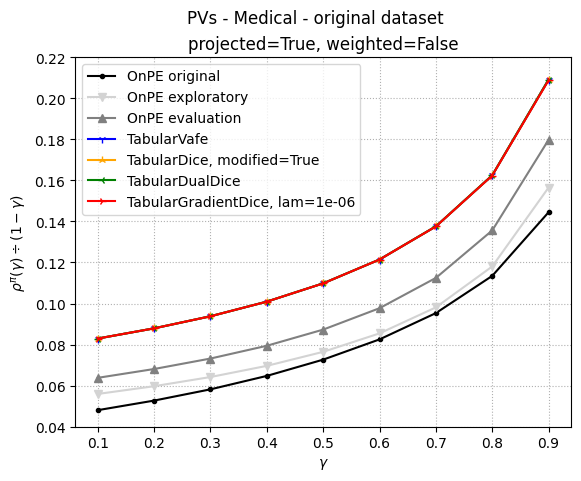

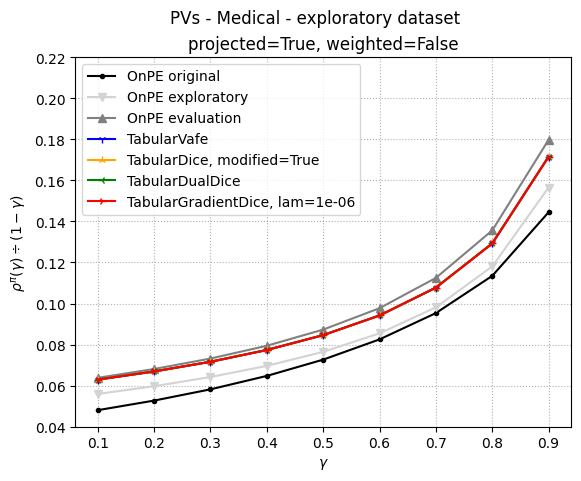

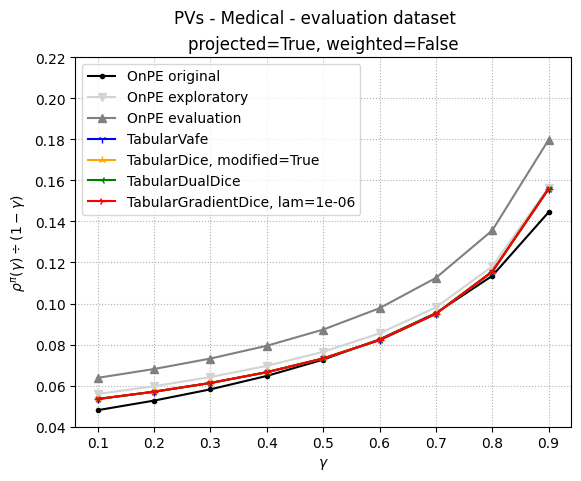

# ---------------------------------------------------------------- #


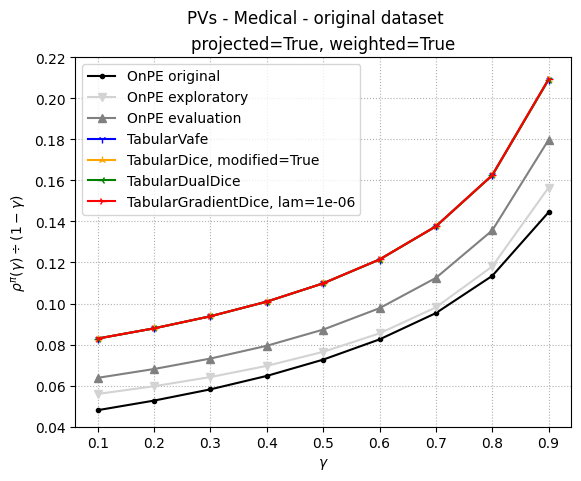

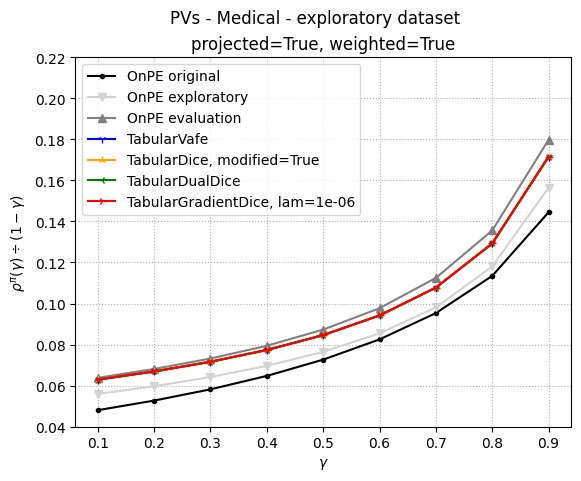

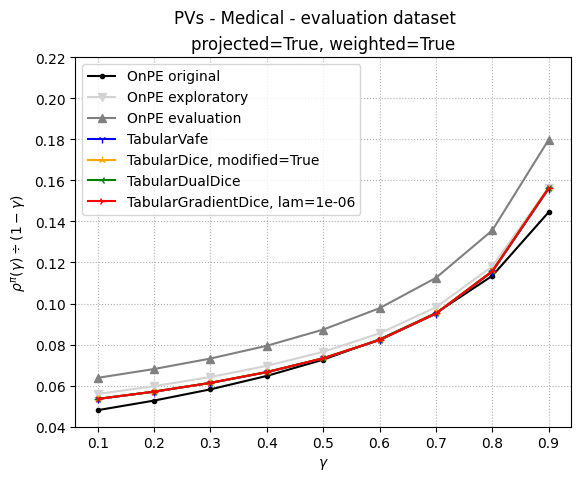

In [96]:
for k in K:
    plot_pvs_wrapped_1(k, weighted=False, errors=False)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_1(k, weighted=True, errors=False)

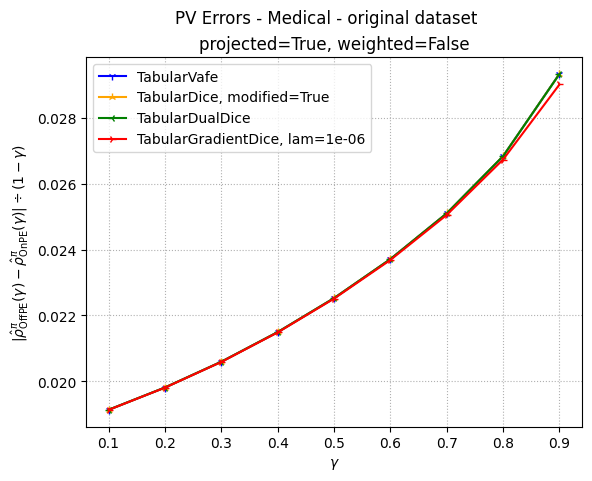

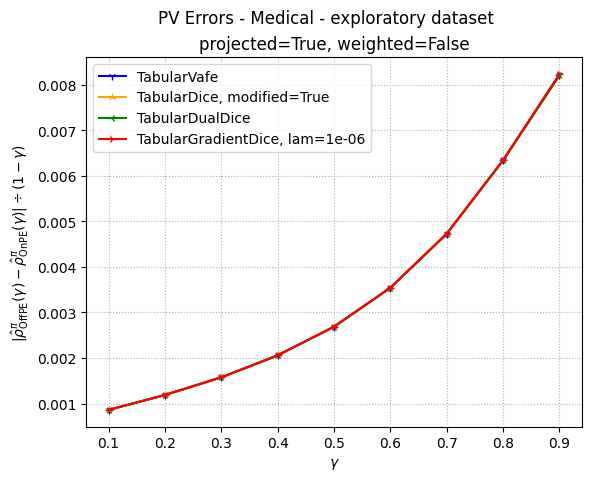

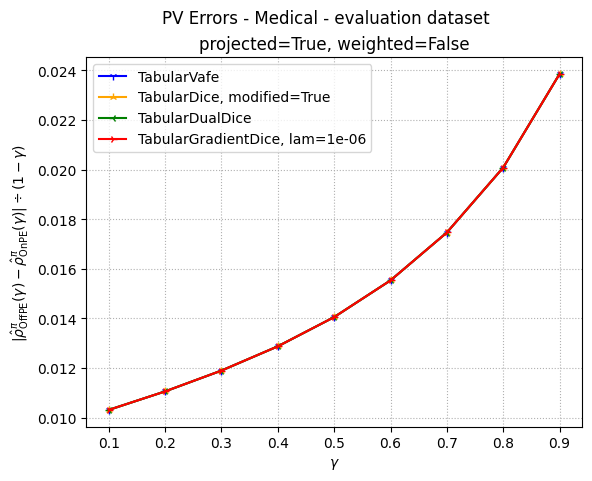

# ---------------------------------------------------------------- #


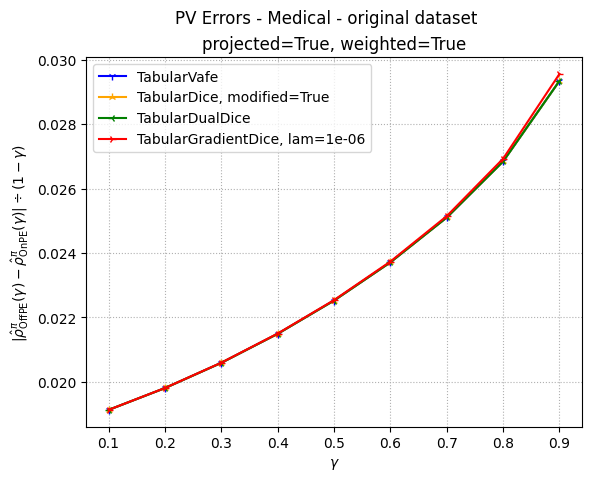

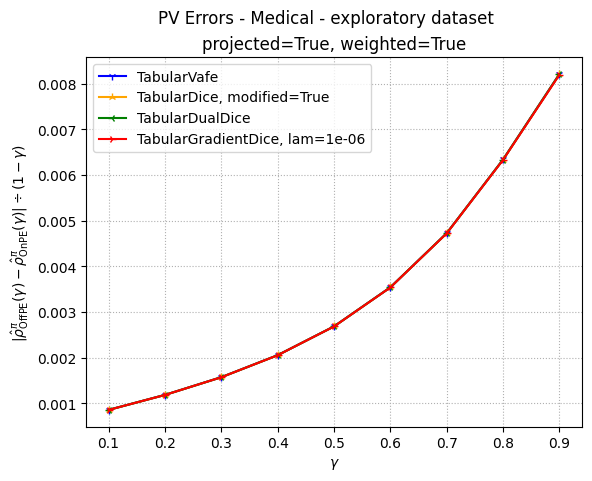

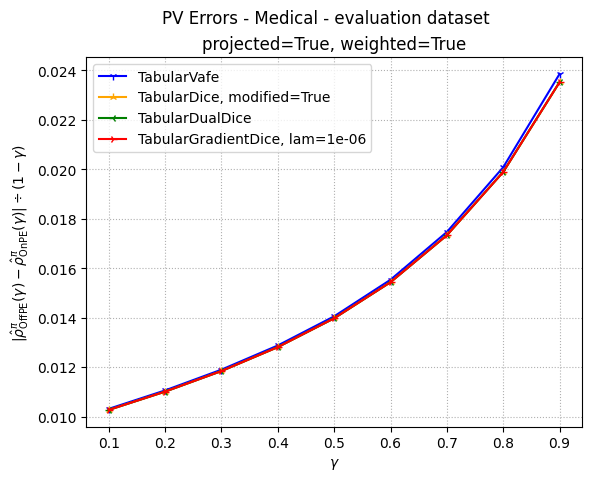

In [97]:
for k in K:
    plot_pvs_wrapped_1(k, weighted=False, errors=True)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_1(k, weighted=True, errors=True)

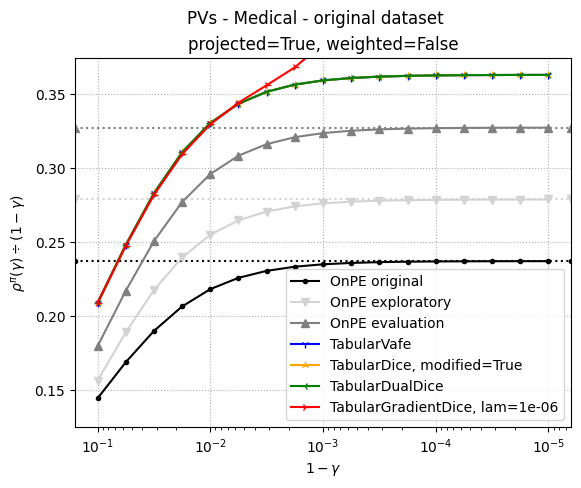

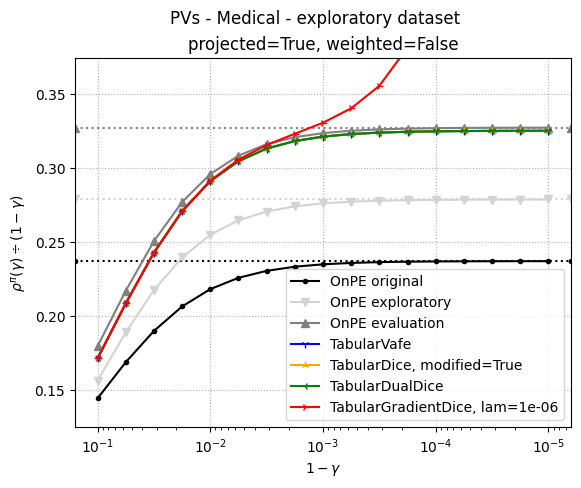

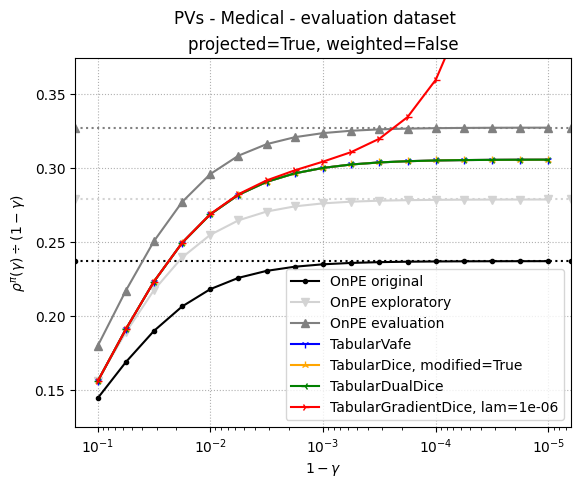

# ---------------------------------------------------------------- #


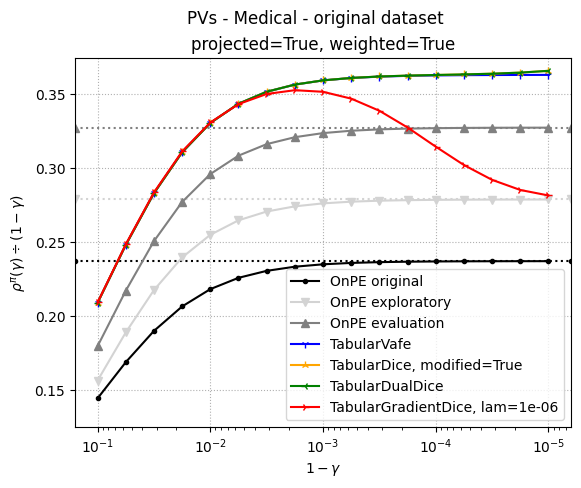

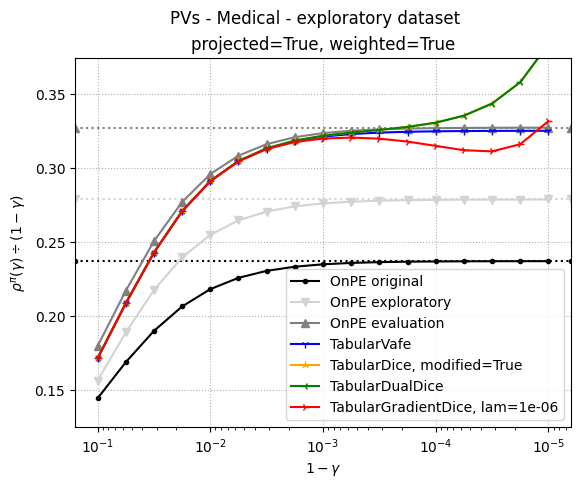

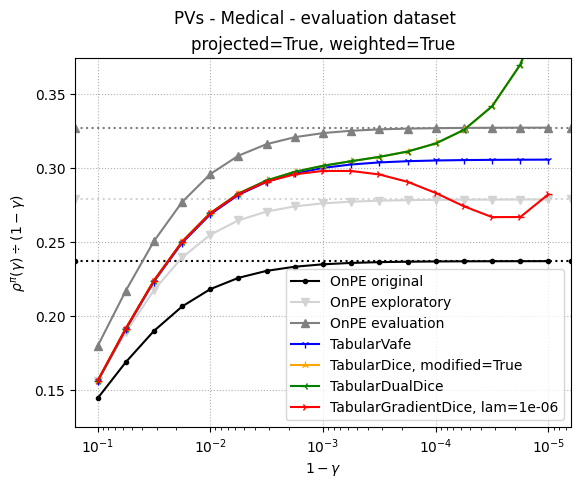

In [113]:
for k in K:
    plot_pvs_wrapped_2(k, weighted=False, errors=False)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_2(k, weighted=True, errors=False)

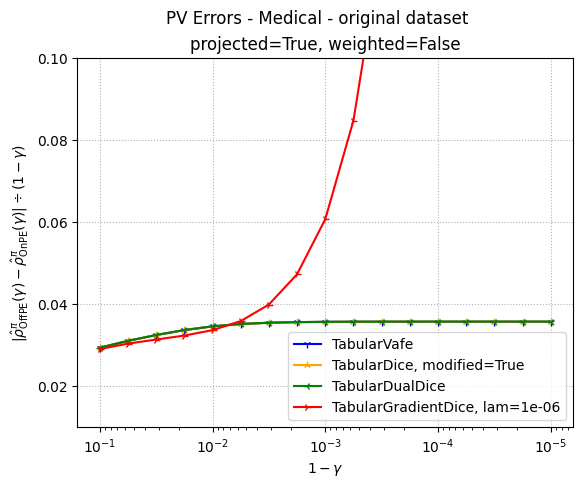

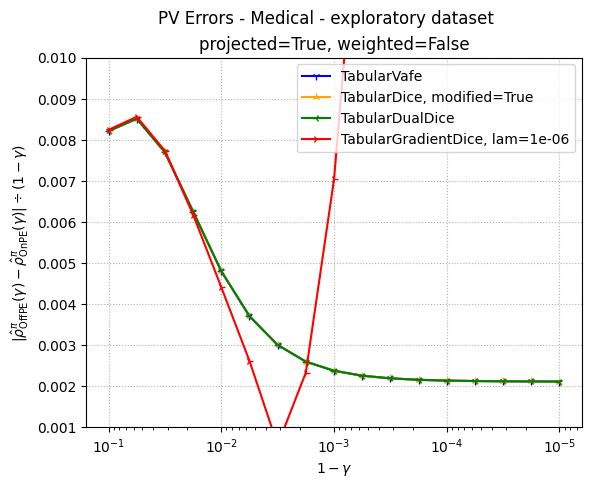

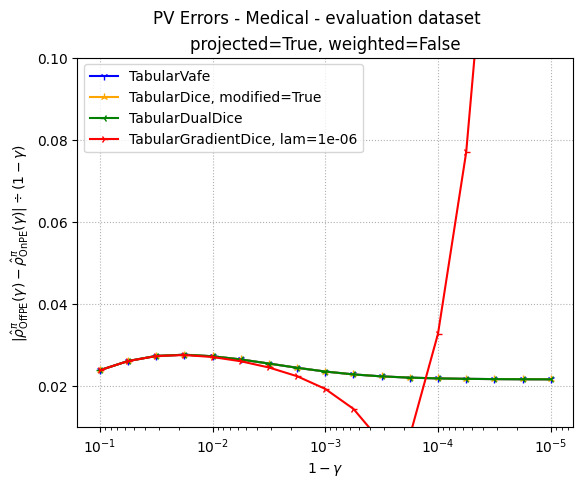

# ---------------------------------------------------------------- #


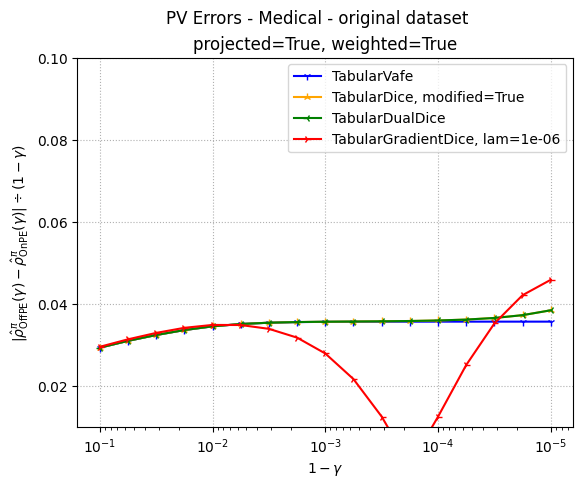

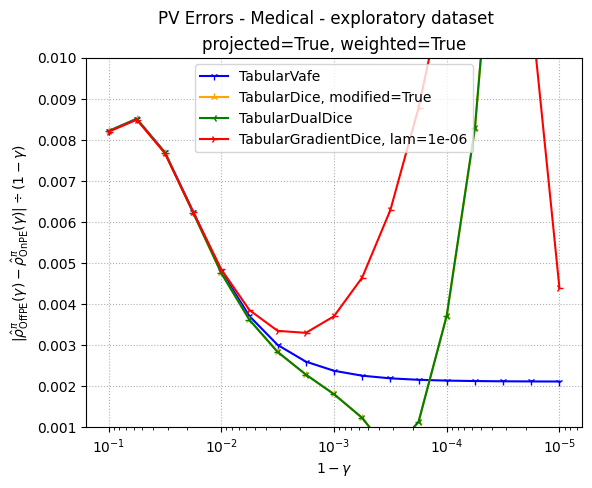

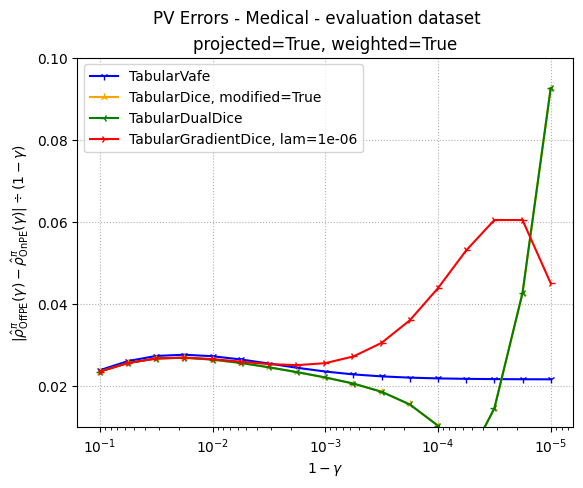

In [114]:
for k in K:
    plot_pvs_wrapped_2(k, weighted=False, errors=True)

print("#", "-"*64, "#")

for k in K:
    plot_pvs_wrapped_2(k, weighted=True, errors=True)

## Success Rates

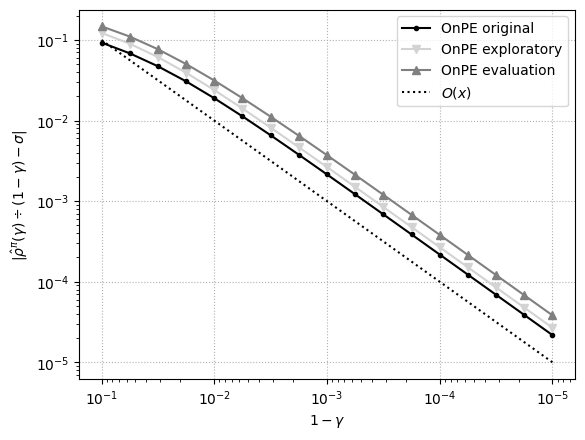

In [ ]:
plot_success_rate_pv_error(
    success_rates=[ success_rate[k] for k in K ],
    estimators=[ estimators_OnPE[k] for k in K ],
    save_dir=config["save_dir_images"],
)

# Test

## Dataset

In [ ]:
display_episodes_dataframe_dataset(
    num_episodes=10, dataframe=test_clustered)

,id,t,obs,act,rew
0,20,0,58,1,0
1,20,1,179,1,0
2,20,2,17,1,0
3,20,3,17,1,0
4,20,4,17,1,0
5,20,5,17,1,0
6,20,6,17,1,0
7,20,7,195,0,0
8,20,8,256,2,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
9,25,0,254,2,0
10,25,1,254,2,0
11,25,2,254,2,1
12,25,3,257,1,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
13,44,0,2,0,0
14,44,1,256,2,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
15,47,0,181,0,0
16,47,1,181,0,0
17,47,2,188,3,0
18,47,3,17,3,0
19,47,4,17,3,0
20,47,5,256,2,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
21,50,0,116,0,0
22,50,1,41,2,0
23,50,2,41,3,0
24,50,3,41,3,0
25,50,4,41,3,0
26,50,5,41,3,0
27,50,6,41,3,0
28,50,7,17,2,0
29,50,8,41,1,0
30,50,9,41,1,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
59,58,0,41,0,0
60,58,1,41,0,0
61,58,2,41,0,0
62,58,3,17,0,0
63,58,4,256,4,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
64,76,0,100,0,0
65,76,1,100,0,0
66,76,2,256,4,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
67,91,0,163,2,0
68,91,1,165,4,0
69,91,2,163,4,1
70,91,3,257,3,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
71,94,0,144,0,0
72,94,1,247,0,0
73,94,2,247,0,0
74,94,3,140,0,0
75,94,4,140,0,0
76,94,5,44,0,0
77,94,6,247,0,0
78,94,7,247,0,0
79,94,8,145,0,0
80,94,9,145,0,0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
85,133,0,202,2,0
86,133,1,202,3,0
87,133,2,202,0,0
88,133,3,256,3,0


# ---------------------------------------------------------------- # 



In [ ]:
display_episodes_dataframe_dataset(
    num_episodes=10, dataset=dataset[""])

,step_type,step_num,observation,action,reward,discount
0,0,0,58,1,0.0,1.0
1,1,1,179,1,0.0,1.0
2,1,2,17,1,0.0,1.0
3,1,3,17,1,0.0,1.0
4,1,4,17,1,0.0,1.0
5,1,5,17,1,0.0,1.0
6,1,6,17,1,0.0,1.0
7,1,7,195,0,0.0,1.0
8,1,8,256,2,0.0,1.0
9,2,9,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,254,2,0.0,1.0
1,1,1,254,2,0.0,1.0
2,1,2,254,2,1.0,1.0
3,1,3,257,2,0.0,1.0
4,2,4,257,0,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,2,0,0.0,1.0
1,1,1,256,1,0.0,1.0
2,2,2,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,181,0,0.0,1.0
1,1,1,181,0,0.0,1.0
2,1,2,188,3,0.0,1.0
3,1,3,17,3,0.0,1.0
4,1,4,17,3,0.0,1.0
5,1,5,256,2,0.0,1.0
6,2,6,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,116,0,0.0,1.0
1,1,1,41,2,0.0,1.0
2,1,2,41,3,0.0,1.0
3,1,3,41,3,0.0,1.0
4,1,4,41,3,0.0,1.0
5,1,5,41,3,0.0,1.0
6,1,6,41,3,0.0,1.0
7,1,7,17,2,0.0,1.0
8,1,8,41,1,0.0,1.0
9,1,9,41,1,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,41,0,0.0,1.0
1,1,1,41,0,0.0,1.0
2,1,2,41,0,0.0,1.0
3,1,3,17,0,0.0,1.0
4,1,4,256,0,0.0,1.0
5,2,5,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,100,0,0.0,1.0
1,1,1,100,0,0.0,1.0
2,1,2,256,3,0.0,1.0
3,2,3,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,163,2,0.0,1.0
1,1,1,165,4,0.0,1.0
2,1,2,163,4,1.0,1.0
3,1,3,257,0,0.0,1.0
4,2,4,257,0,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,144,0,0.0,1.0
1,1,1,247,0,0.0,1.0
2,1,2,247,0,0.0,1.0
3,1,3,140,0,0.0,1.0
4,1,4,140,0,0.0,1.0
5,1,5,44,0,0.0,1.0
6,1,6,247,0,0.0,1.0
7,1,7,247,0,0.0,1.0
8,1,8,145,0,0.0,1.0
9,1,9,145,0,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,202,2,0.0,1.0
1,1,1,202,3,0.0,1.0
2,1,2,202,0,0.0,1.0
3,1,3,256,1,0.0,1.0
4,2,4,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



In [ ]:
display_episodes_dataframe_dataset(
    num_episodes=10, dataframe=test_clustered, dataset=dataset[""])

,id,t,obs,act,rew
0,20,0,58,1,0
1,20,1,179,1,0
2,20,2,17,1,0
3,20,3,17,1,0
4,20,4,17,1,0
5,20,5,17,1,0
6,20,6,17,1,0
7,20,7,195,0,0
8,20,8,256,2,0


,step_type,step_num,observation,action,reward,discount
0,0,0,58,1,0.0,1.0
1,1,1,179,1,0.0,1.0
2,1,2,17,1,0.0,1.0
3,1,3,17,1,0.0,1.0
4,1,4,17,1,0.0,1.0
5,1,5,17,1,0.0,1.0
6,1,6,17,1,0.0,1.0
7,1,7,195,0,0.0,1.0
8,1,8,256,2,0.0,1.0
9,2,9,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
9,25,0,254,2,0
10,25,1,254,2,0
11,25,2,254,2,1
12,25,3,257,1,0


,step_type,step_num,observation,action,reward,discount
0,0,0,254,2,0.0,1.0
1,1,1,254,2,0.0,1.0
2,1,2,254,2,1.0,1.0
3,1,3,257,2,0.0,1.0
4,2,4,257,0,0.0,0.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
13,44,0,2,0,0
14,44,1,256,2,0


,step_type,step_num,observation,action,reward,discount
0,0,0,2,0,0.0,1.0
1,1,1,256,1,0.0,1.0
2,2,2,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
15,47,0,181,0,0
16,47,1,181,0,0
17,47,2,188,3,0
18,47,3,17,3,0
19,47,4,17,3,0
20,47,5,256,2,0


,step_type,step_num,observation,action,reward,discount
0,0,0,181,0,0.0,1.0
1,1,1,181,0,0.0,1.0
2,1,2,188,3,0.0,1.0
3,1,3,17,3,0.0,1.0
4,1,4,17,3,0.0,1.0
5,1,5,256,2,0.0,1.0
6,2,6,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
21,50,0,116,0,0
22,50,1,41,2,0
23,50,2,41,3,0
24,50,3,41,3,0
25,50,4,41,3,0
26,50,5,41,3,0
27,50,6,41,3,0
28,50,7,17,2,0
29,50,8,41,1,0
30,50,9,41,1,0


,step_type,step_num,observation,action,reward,discount
0,0,0,116,0,0.0,1.0
1,1,1,41,2,0.0,1.0
2,1,2,41,3,0.0,1.0
3,1,3,41,3,0.0,1.0
4,1,4,41,3,0.0,1.0
5,1,5,41,3,0.0,1.0
6,1,6,41,3,0.0,1.0
7,1,7,17,2,0.0,1.0
8,1,8,41,1,0.0,1.0
9,1,9,41,1,0.0,1.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
59,58,0,41,0,0
60,58,1,41,0,0
61,58,2,41,0,0
62,58,3,17,0,0
63,58,4,256,4,0


,step_type,step_num,observation,action,reward,discount
0,0,0,41,0,0.0,1.0
1,1,1,41,0,0.0,1.0
2,1,2,41,0,0.0,1.0
3,1,3,17,0,0.0,1.0
4,1,4,256,0,0.0,1.0
5,2,5,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
64,76,0,100,0,0
65,76,1,100,0,0
66,76,2,256,4,0


,step_type,step_num,observation,action,reward,discount
0,0,0,100,0,0.0,1.0
1,1,1,100,0,0.0,1.0
2,1,2,256,3,0.0,1.0
3,2,3,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
67,91,0,163,2,0
68,91,1,165,4,0
69,91,2,163,4,1
70,91,3,257,3,0


,step_type,step_num,observation,action,reward,discount
0,0,0,163,2,0.0,1.0
1,1,1,165,4,0.0,1.0
2,1,2,163,4,1.0,1.0
3,1,3,257,0,0.0,1.0
4,2,4,257,0,0.0,0.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
71,94,0,144,0,0
72,94,1,247,0,0
73,94,2,247,0,0
74,94,3,140,0,0
75,94,4,140,0,0
76,94,5,44,0,0
77,94,6,247,0,0
78,94,7,247,0,0
79,94,8,145,0,0
80,94,9,145,0,0


,step_type,step_num,observation,action,reward,discount
0,0,0,144,0,0.0,1.0
1,1,1,247,0,0.0,1.0
2,1,2,247,0,0.0,1.0
3,1,3,140,0,0.0,1.0
4,1,4,140,0,0.0,1.0
5,1,5,44,0,0.0,1.0
6,1,6,247,0,0.0,1.0
7,1,7,247,0,0.0,1.0
8,1,8,145,0,0.0,1.0
9,1,9,145,0,0.0,1.0


# ---------------------------------------------------------------- # 



,id,t,obs,act,rew
85,133,0,202,2,0
86,133,1,202,3,0
87,133,2,202,0,0
88,133,3,256,3,0


,step_type,step_num,observation,action,reward,discount
0,0,0,202,2,0.0,1.0
1,1,1,202,3,0.0,1.0
2,1,2,202,0,0.0,1.0
3,1,3,256,1,0.0,1.0
4,2,4,256,0,0.0,0.0


# ---------------------------------------------------------------- # 



In [ ]:
display_episodes_dataframe_dataset(
    num_episodes=10, dataset=dataset["ex"])

,step_type,step_num,observation,action,reward,discount
0,0,0,97,2,0.0,1.0
1,1,1,104,3,0.0,1.0
2,1,2,24,1,0.0,1.0
3,1,3,122,1,0.0,1.0
4,1,4,244,2,0.0,1.0
5,1,5,48,3,0.0,1.0
6,1,6,48,2,0.0,1.0
7,1,7,244,4,0.0,1.0
8,1,8,48,3,0.0,1.0
9,1,9,244,4,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,195,0,0.0,1.0
1,1,1,195,0,0.0,1.0
2,1,2,195,1,0.0,1.0
3,1,3,195,4,0.0,1.0
4,1,4,38,2,0.0,1.0
5,1,5,38,0,0.0,1.0
6,1,6,38,4,0.0,1.0
7,1,7,38,2,0.0,1.0
8,1,8,38,2,0.0,1.0
9,1,9,256,0,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,58,4,0.0,1.0
1,1,1,179,3,0.0,1.0
2,1,2,179,1,0.0,1.0
3,1,3,58,2,0.0,1.0
4,1,4,179,4,0.0,1.0
5,1,5,58,2,0.0,1.0
6,1,6,58,2,0.0,1.0
7,1,7,179,4,0.0,1.0
8,1,8,58,2,0.0,1.0
9,1,9,179,1,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,144,1,0.0,1.0
1,1,1,45,4,0.0,1.0
2,1,2,58,1,0.0,1.0
3,1,3,179,1,0.0,1.0
4,1,4,179,3,0.0,1.0
5,1,5,179,2,0.0,1.0
6,1,6,179,4,0.0,1.0
7,1,7,179,1,0.0,1.0
8,1,8,58,2,0.0,1.0
9,1,9,256,1,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,58,2,0.0,1.0
1,1,1,58,4,0.0,1.0
2,1,2,256,0,0.0,1.0
3,2,3,256,2,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,183,3,1.0,1.0
1,1,1,257,0,0.0,1.0
2,2,2,257,2,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,247,4,0.0,1.0
1,1,1,144,0,0.0,1.0
2,1,2,183,3,0.0,1.0
3,1,3,86,0,0.0,1.0
4,1,4,212,1,0.0,1.0
5,1,5,130,0,0.0,1.0
6,1,6,30,1,0.0,1.0
7,1,7,30,0,0.0,1.0
8,1,8,30,0,0.0,1.0
9,1,9,30,0,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,144,1,0.0,1.0
1,1,1,52,2,0.0,1.0
2,1,2,52,1,0.0,1.0
3,1,3,52,1,0.0,1.0
4,1,4,52,4,0.0,1.0
5,1,5,145,2,0.0,1.0
6,1,6,145,4,0.0,1.0
7,1,7,52,2,0.0,1.0
8,1,8,256,0,0.0,1.0
9,2,9,256,4,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,41,0,0.0,1.0
1,1,1,181,1,0.0,1.0
2,1,2,140,2,0.0,1.0
3,1,3,140,2,0.0,1.0
4,1,4,140,3,0.0,1.0
5,1,5,175,4,0.0,1.0
6,1,6,175,2,0.0,1.0
7,1,7,175,4,0.0,1.0
8,1,8,175,2,0.0,1.0
9,1,9,105,2,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,52,2,0.0,1.0
1,1,1,52,3,0.0,1.0
2,1,2,52,4,0.0,1.0
3,1,3,256,1,0.0,1.0
4,2,4,256,4,0.0,0.0


# ---------------------------------------------------------------- # 



In [ ]:
display_episodes_dataframe_dataset(
    num_episodes=10, dataset=dataset["ev"])

,step_type,step_num,observation,action,reward,discount
0,0,0,97,1,0.0,1.0
1,1,1,42,1,0.0,1.0
2,1,2,42,3,0.0,1.0
3,1,3,25,1,0.0,1.0
4,1,4,3,1,0.0,1.0
5,1,5,3,1,0.0,1.0
6,1,6,3,1,0.0,1.0
7,1,7,195,1,0.0,1.0
8,1,8,77,3,0.0,1.0
9,1,9,202,2,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,244,2,0.0,1.0
1,1,1,244,2,0.0,1.0
2,1,2,48,0,0.0,1.0
3,1,3,48,2,0.0,1.0
4,1,4,256,4,0.0,1.0
5,2,5,256,4,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,100,3,0.0,1.0
1,1,1,100,3,0.0,1.0
2,1,2,100,1,0.0,1.0
3,1,3,25,1,0.0,1.0
4,1,4,185,4,0.0,1.0
...,...,...,...,...,...,...
763,1,763,119,1,0.0,1.0
764,1,764,48,3,0.0,1.0
765,1,765,48,2,0.0,1.0
766,1,766,256,2,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,238,2,0.0,1.0
1,1,1,67,3,0.0,1.0
2,1,2,41,1,0.0,1.0
3,1,3,41,1,0.0,1.0
4,1,4,51,1,0.0,1.0
5,1,5,155,0,0.0,1.0
6,1,6,155,0,0.0,1.0
7,1,7,254,1,1.0,1.0
8,1,8,257,2,0.0,1.0
9,2,9,257,2,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,129,3,0.0,1.0
1,1,1,129,3,0.0,1.0
2,1,2,208,2,0.0,1.0
3,1,3,208,4,0.0,1.0
4,1,4,208,2,0.0,1.0
5,1,5,198,3,0.0,1.0
6,1,6,12,4,1.0,1.0
7,1,7,257,3,0.0,1.0
8,2,8,257,3,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,97,4,0.0,1.0
1,1,1,25,1,0.0,1.0
2,1,2,185,4,0.0,1.0
3,1,3,25,1,0.0,1.0
4,1,4,25,2,0.0,1.0
5,1,5,7,4,0.0,1.0
6,1,6,45,4,0.0,1.0
7,1,7,45,1,0.0,1.0
8,1,8,45,3,0.0,1.0
9,1,9,45,4,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,25,1,0.0,1.0
1,1,1,97,2,0.0,1.0
2,1,2,97,2,0.0,1.0
3,1,3,42,1,0.0,1.0
4,1,4,7,3,0.0,1.0
5,1,5,45,3,0.0,1.0
6,1,6,45,3,0.0,1.0
7,1,7,7,4,0.0,1.0
8,1,8,7,2,0.0,1.0
9,1,9,25,2,0.0,1.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,12,4,0.0,1.0
1,1,1,182,2,0.0,1.0
2,1,2,198,3,0.0,1.0
3,1,3,12,3,0.0,1.0
4,1,4,12,4,1.0,1.0
5,1,5,257,1,0.0,1.0
6,2,6,257,1,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,100,3,0.0,1.0
1,1,1,38,0,1.0,1.0
2,1,2,257,2,0.0,1.0
3,2,3,257,4,0.0,0.0


# ---------------------------------------------------------------- # 



,step_type,step_num,observation,action,reward,discount
0,0,0,58,4,0.0,1.0
1,1,1,179,4,0.0,1.0
2,1,2,179,3,0.0,1.0
3,1,3,179,3,0.0,1.0
4,1,4,179,4,0.0,1.0
5,1,5,58,4,0.0,1.0
6,1,6,179,2,0.0,1.0
7,1,7,45,3,0.0,1.0
8,1,8,45,3,0.0,1.0
9,1,9,45,3,0.0,1.0


# ---------------------------------------------------------------- # 



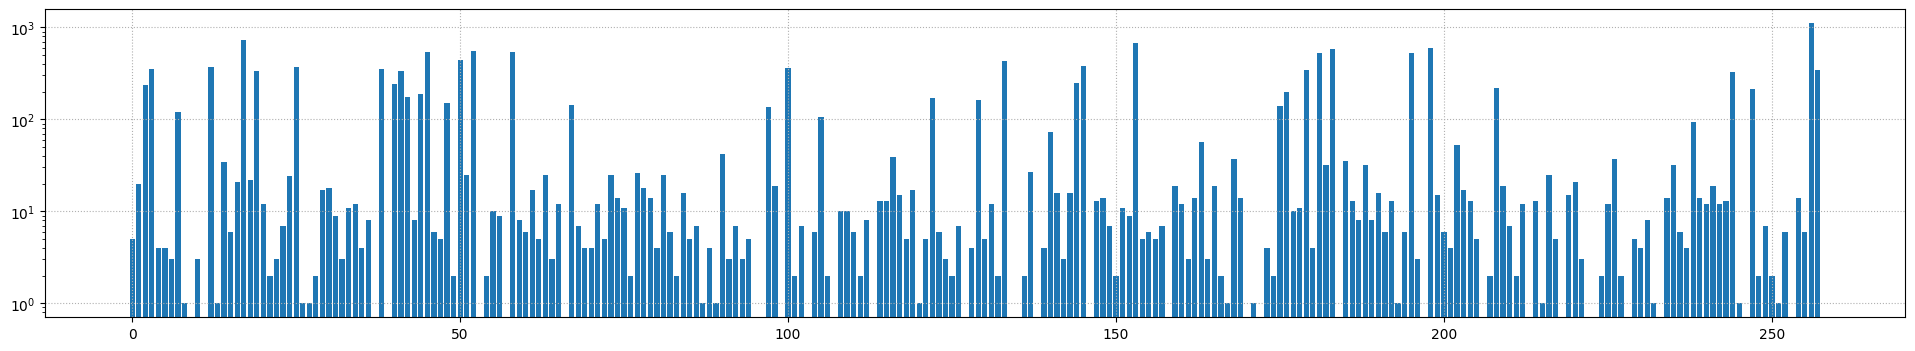

In [ ]:
plot_observations(dataset=dataset)

## Environment

In [ ]:
test_env(
    env=env_test,
    get_act=get_act_model_exploratory,
    num_trajectory=1_000,
    verbosity=1,
)

100%|██████████| 1000/1000 [00:03<00:00, 253.61it/s]


{'distinct_absolute': (5.84, 3.9044077655900646),
 'distinct_relative': (0.5780842394276596, 0.24751947387148787),
 'all': (13.635, 12.534583160201219)}

In [ ]:
test_env(
    env=env_test,
    get_act=get_act_model_evaluation,
    num_trajectory=1_000,
    verbosity=1,
)

100%|██████████| 1000/1000 [00:04<00:00, 217.89it/s]


{'distinct_absolute': (5.765, 3.7357428980056966),
 'distinct_relative': (0.5478743143271877, 0.26124926214474836),
 'all': (15.838, 21.97457066702328)}

## Estimators

/Users/richardweiss/Library/CloudStorage/OneDrive-Persönlich/Masterarbeit/dice_rl_TU_Vienna/dice_rl_plugins/estimators/tabular/test.py:195: DeprecationWarning: invalid escape sequence '\q'
  plt.suptitle(title_prefix + "; " + f"${x}" + ", \quad " + f"{y}$", y=1.025)


(s, a) visited:
{'absolute': 663, 'relative': 0.513953488372093}
(s, a) not visited:
{'absolute': 627, 'relative': 0.48604651162790696}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 0
# dD_bar[i], but d0_bar[i] != 0: 0

# ---------------------------------------------------------------- # 



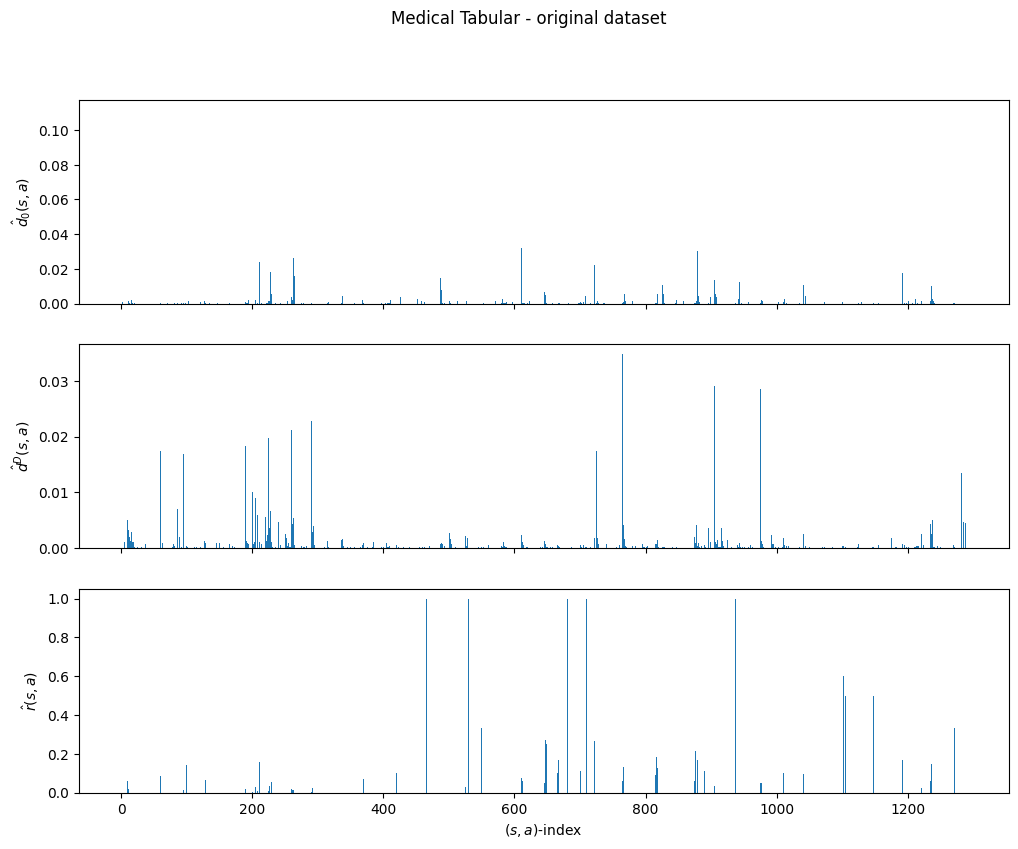

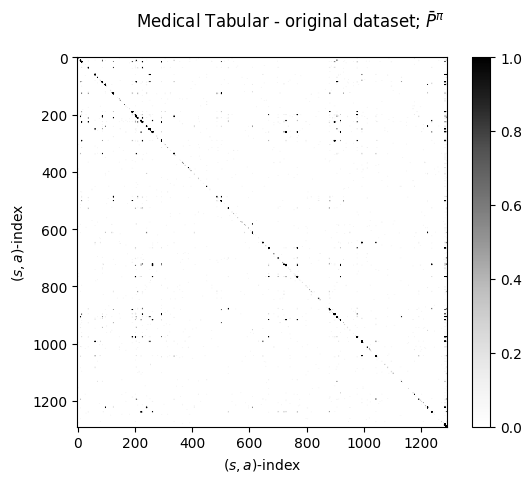

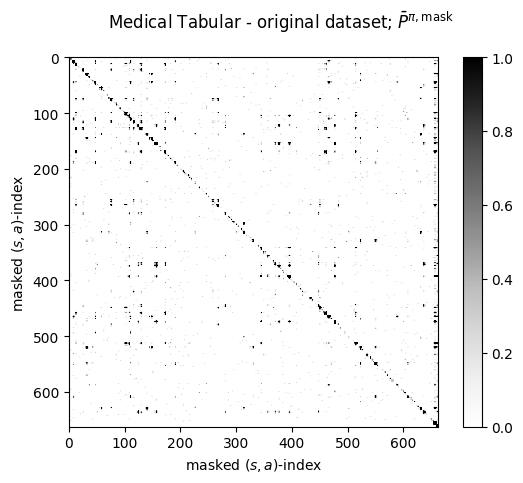

# ---------------------------------------------------------------- # 



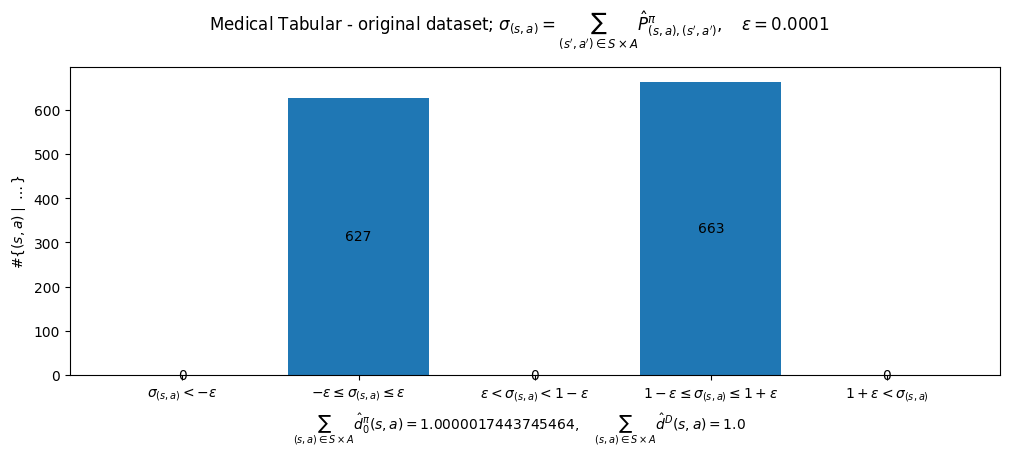

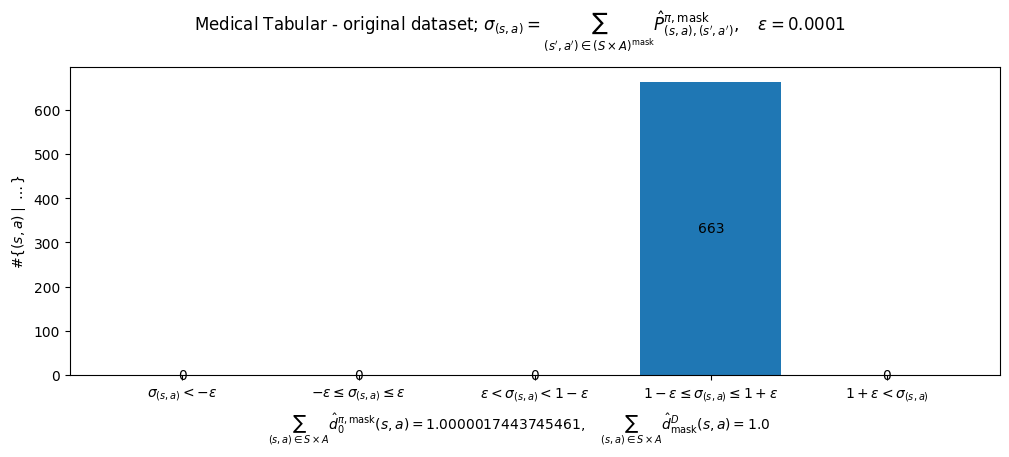

# ---------------------------------------------------------------- # 



In [131]:
k = ""

test_aux_estimates(
    aux_estimates=aux_estimates[k],
    title_prefix=f"Medical Tabular - {names[k]} dataset",
    save_dir=os.path.join(save_dir_images, "aux_estimates"),
)

(s, a) visited:
{'absolute': 662, 'relative': 0.5131782945736434}
(s, a) not visited:
{'absolute': 628, 'relative': 0.4868217054263566}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 0
# dD_bar[i], but d0_bar[i] != 0: 0

# ---------------------------------------------------------------- # 



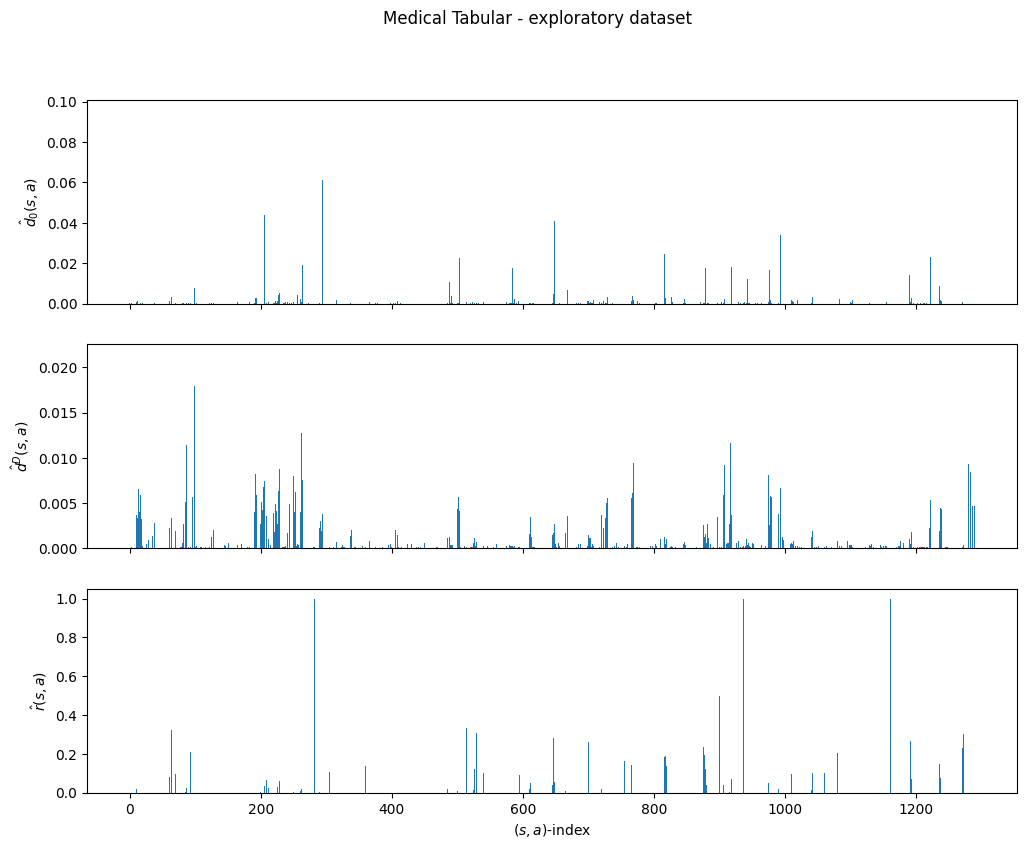

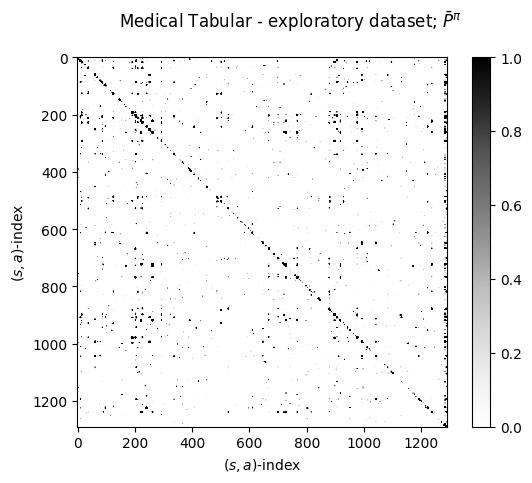

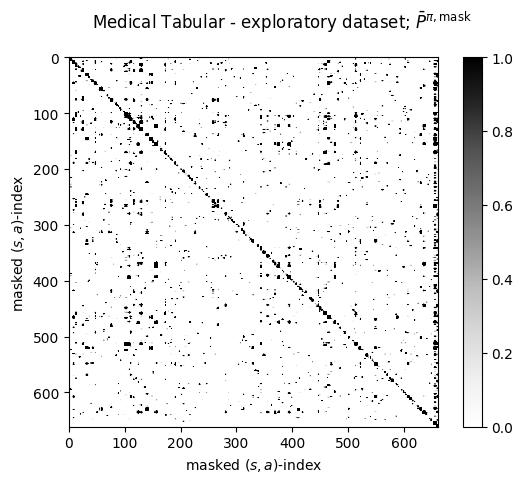

# ---------------------------------------------------------------- # 



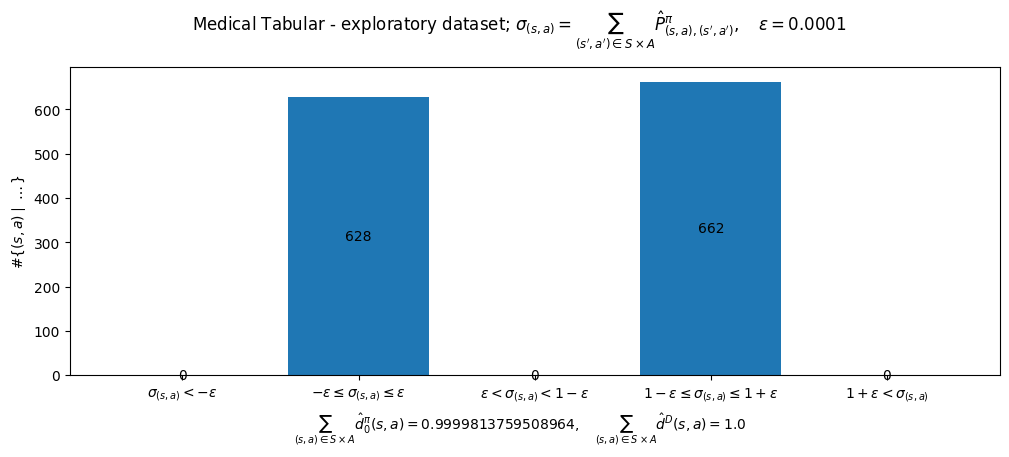

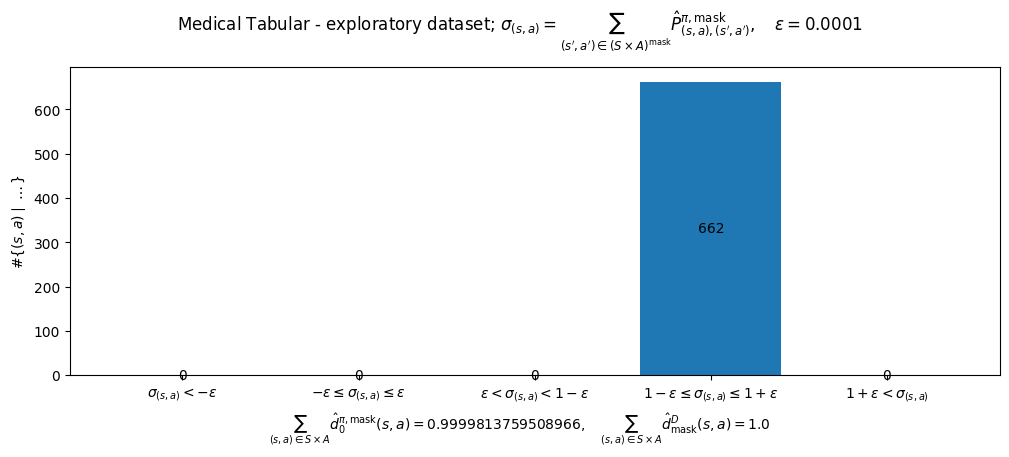

# ---------------------------------------------------------------- # 



In [132]:
k = "ex"

test_aux_estimates(
    aux_estimates=aux_estimates[k],
    title_prefix=f"Medical Tabular - {names[k]} dataset",
    save_dir=os.path.join(save_dir_images, "aux_estimates"),
)

(s, a) visited:
{'absolute': 569, 'relative': 0.44108527131782943}
(s, a) not visited:
{'absolute': 721, 'relative': 0.5589147286821705}

# dD_bar[i] == 0, but P_bar[i, :] != 0: 0
# dD_bar[i] == 0, but P_bar[:, i] != 0: 415
# dD_bar[i], but d0_bar[i] != 0: 57

# ---------------------------------------------------------------- # 



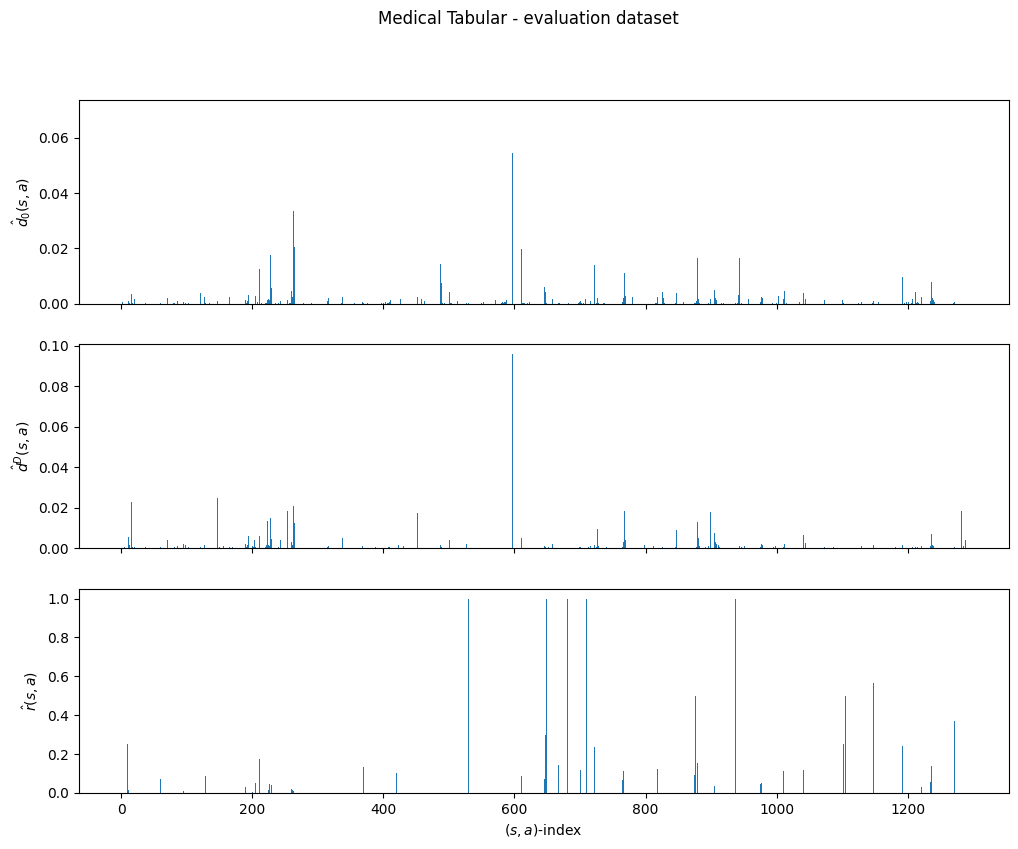

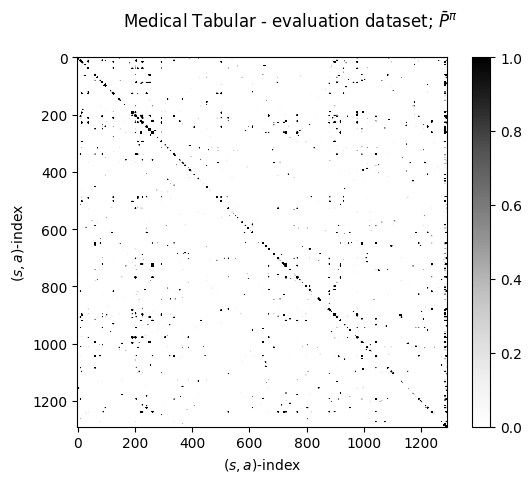

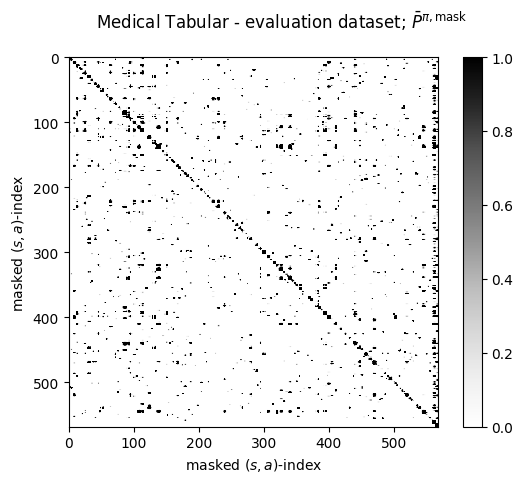

# ---------------------------------------------------------------- # 



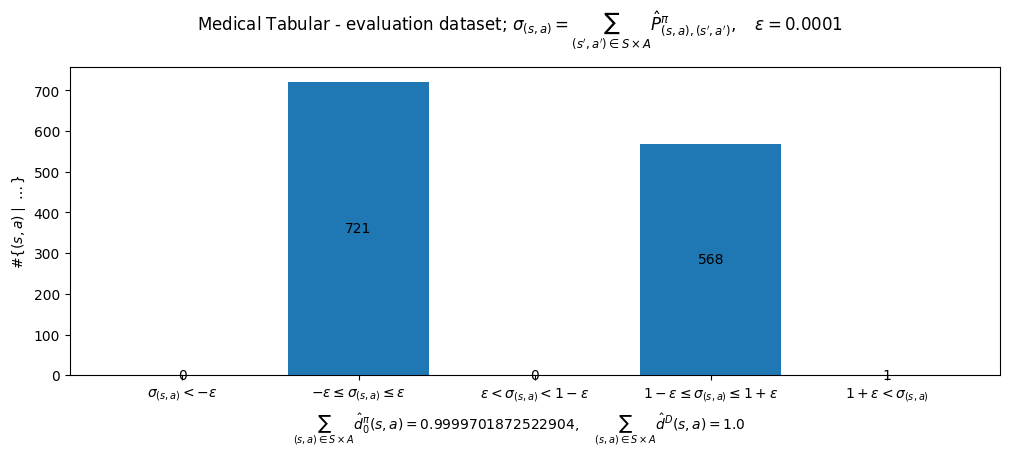

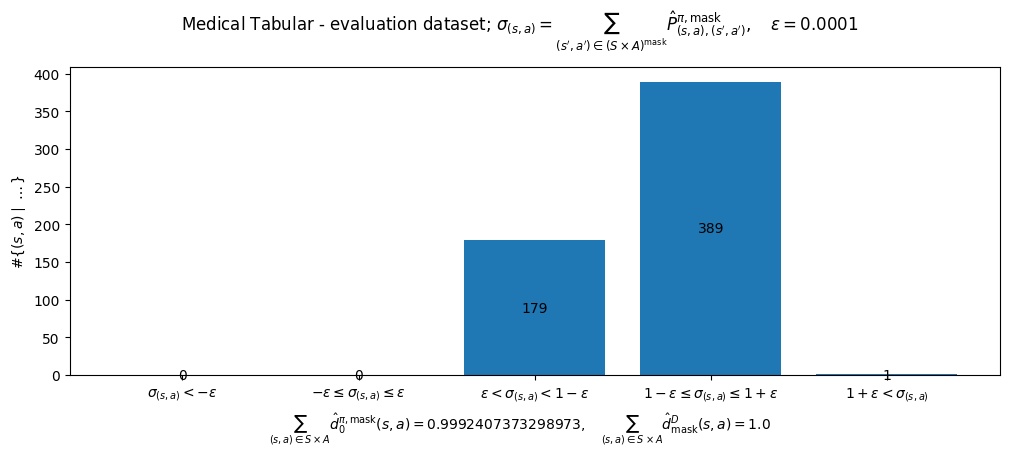

# ---------------------------------------------------------------- # 



In [133]:
k = "ev"

test_aux_estimates(
    aux_estimates=aux_estimates[k],
    title_prefix=f"Medical Tabular - {names[k]} dataset",
    save_dir=os.path.join(save_dir_images, "aux_estimates"),
)

## From Scratch

In [111]:
def from_scratch_OnPolicy(rewards, gamma):
    discounts = gamma ** np.arange(rewards.shape[-1])

    x = (1 - gamma) * np.mean(rewards @ discounts)
    y = x / (1 - gamma)

    return np.array([x, y])

In [112]:
def from_scratch_TabularDice(
        dataset, aux_estimates, gamma,
        modified, projected):

    sdc_hat, _ = solve_backwards_bellman_equations_approximate(
        *aux_estimates, gamma, modified, projected, ) # type: ignore

    all_steps = dataset.get_all_steps()

    o = tf.cast(all_steps.observation, dtype=tf.int32)
    a = tf.cast(all_steps.action,      dtype=tf.int32)
    indices = o * 5 + a # type: ignore

    w = sdc_hat[indices]
    r = np.array(all_steps.reward)

    if not np.prod(w >= 0):
        warnings.warn("negative sdc value encountered", UserWarning)

    x = np.array([
        np.mean(w * r),
        np.sum(w * r) / np.sum(w),
    ])
    y = x / (1 - gamma)

    return np.array([x, y])

In [113]:
def from_scratch(dataset, aux_estimates, projected):

    gamma = 0.9

    x = from_scratch_OnPolicy(rewards=rewards["ev"], gamma=gamma)

    y = from_scratch_TabularDice(
        dataset=dataset,
        aux_estimates=aux_estimates,
        gamma=gamma,
        modified=False,
        projected=projected,
    )

    z = from_scratch_TabularDice(
        dataset=dataset,
        aux_estimates=aux_estimates,
        gamma=gamma,
        modified=True,
        projected=projected,
    )

    display(x)
    display(y); display(z)

In [114]:
# from_scratch

print("#", "-"*64, "#")

from_scratch(
    dataset=dataset,
    aux_estimates=aux_estimates[""],
    projected=False,
)

print("#", "-"*64, "#")

from_scratch(
    dataset=dataset,
    aux_estimates=aux_estimates[""],
    projected=True,
)

print("#", "-"*64, "#")

from_scratch(
    dataset=dataset["ex"],
    aux_estimates=aux_estimates["ex"],
    projected=True,
)

print("#", "-"*64, "#")

from_scratch(
    dataset=dataset["ev"],
    aux_estimates=aux_estimates["ev"],
    projected=True,
)

print("#", "-"*64, "#")

# ---------------------------------------------------------------- #


array([0.01797413, 0.17974135])

array([[0.02090813, 0.0209081 ],
       [0.20908129, 0.20908098]])

array([[0.02090813, 0.0209081 ],
       [0.20908129, 0.20908098]])

# ---------------------------------------------------------------- #


array([0.01797413, 0.17974135])

array([[0.02090813, 0.0209081 ],
       [0.20908129, 0.20908098]])

array([[0.02090813, 0.0209081 ],
       [0.20908129, 0.20908098]])

# ---------------------------------------------------------------- #


array([0.01797413, 0.17974135])

array([[0.01715318, 0.01715356],
       [0.17153175, 0.17153561]])

array([[0.01715318, 0.01715356],
       [0.17153175, 0.17153561]])

# ---------------------------------------------------------------- #


array([0.01797413, 0.17974135])

array([[0.01558881, 0.01562188],
       [0.15588814, 0.15621878]])

array([[0.01558881, 0.01562188],
       [0.15588814, 0.15621878]])

# ---------------------------------------------------------------- #


In [159]:
def test_from_scratch():
    x = test_from_scratch_OnPE()
    y = test_from_scratch_DICE()

    print("OnPE error:", x)
    print("DICE error (s & w):", y)


def test_from_scratch_OnPE():
    pv_1, _ = from_scratch_OnPolicy(
        rewards=rewards["ev"], gamma=0.9, )

    pv_2 = get_policy_value["ev"](gamma=0.9)

    return pv_1 - pv_2


def test_from_scratch_DICE():
    estimator = TabularDice(
        dataset=dataset,
        evaluation_policy=evaluation_policy,
        aux_estimates=aux_estimates[""],
    )

    s_error = []
    w_error = []

    gammas = np.arange(0.1, 1, 0.1)
    for gamma in gammas:

        *_, pv_1_s = estimator.solve(gamma, modified=True, projected=True, weighted=False)
        *_, pv_1_w = estimator.solve(gamma, modified=True, projected=True, weighted=True)

        (pv_2_s, pv_2_w), _ = from_scratch_TabularDice(
            dataset=dataset,
            aux_estimates=aux_estimates[""],
            gamma=gamma,
            modified=True, projected=True,
        )

        s_error.append( np.abs( float(pv_1_s) - pv_2_s ) ) # type: ignore
        w_error.append( np.abs( float(pv_1_w) - pv_2_w ) ) # type: ignore

    return np.max(s_error), np.max(w_error)

In [160]:
test_from_scratch()

OnPE error: 0.0
DICE error (s & w): (3.926466124459793e-09, 1.4395106849585115e-08)
